# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
%matplotlib inline

#import pyspark libraries
import pyspark
from pyspark import SparkConf

# import sql Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

# import ml Spark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("My Sparkify app") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1613925507799'),
 ('spark.driver.host', 'cacab00d4063'),
 ('spark.driver.port', '40911'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'My Sparkify app')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# import mini-dataset file
file = "./mini_sparkify_event_data.json"
df = spark.read.json(file)

In [51]:
# Let's calculate the number of rows the file has --> 286.500 rows
df.count()

286500

# Drop Rows with Missing Values
As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [44]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [45]:
df_valid.count()

286500

In [46]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [49]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [50]:
df_valid.count()

278154

In [63]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
# Let's take an overview of the mini dataset file --> 
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
# Let's take an overview of the schema of the dataset file
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Let's see how many registries the file has --> we have 286.500 rows
df.count()

286500

In [9]:
# Let's take a look at the first lines of the file, to see what they look like
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
# Let's see just one row
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [11]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [15]:
# Let's have an statistic overview of the dataset --> but with this view it is difficult to see...
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [16]:
# Let's go field by field 
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [17]:
df.describe('auth').show()

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+



In [18]:
df.describe('firstName').show()

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+



In [17]:
df.describe('gender').show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



In [18]:
df.describe('itemInSession').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [19]:
df.describe('lastName').show()

+-------+--------+
|summary|lastName|
+-------+--------+
|  count|  278154|
|   mean|    null|
| stddev|    null|
|    min|   Adams|
|    max|  Wright|
+-------+--------+



In [20]:
df.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [21]:
df.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|286500|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



In [22]:
df.describe('location').show()

+-------+-----------------+
|summary|         location|
+-------+-----------------+
|  count|           278154|
|   mean|             null|
| stddev|             null|
|    min|       Albany, OR|
|    max|Winston-Salem, NC|
+-------+-----------------+



In [23]:
df.describe('method').show()

+-------+------+
|summary|method|
+-------+------+
|  count|286500|
|   mean|  null|
| stddev|  null|
|    min|   GET|
|    max|   PUT|
+-------+------+



In [24]:
df.describe('page').show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 286500|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [20]:
df.describe('registration').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [25]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [26]:
df.describe('song').show()

+-------+--------------------+
|summary|                song|
+-------+--------------------+
|  count|              228108|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|ÃÂg ÃÂtti Gr...|
|    max|ÃÂau hafa slopp...|
+-------+--------------------+



In [20]:
df.describe('status').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [27]:
df.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [29]:
df.describe('userAgent').show()

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+



In [30]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [12]:
df.select("userID").show()

+------+
|userID|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
|     9|
|     9|
|    30|
|     9|
|     9|
|    30|
|     9|
|    74|
|    30|
|     9|
+------+
only showing top 20 rows



In [19]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [21]:
df.select(["UserId", "firstname", "page", "song"]).where(df.userId=="30").collect()

[Row(UserId='30', firstname='Colin', page='NextSong', song='Rockpools'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Time For Miracles'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(UserId='30', firstname='Colin', page='Add to Playlist', song=None),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Fuck Kitty'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Jade'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='So-Called Friends'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Represent'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Here I Am'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album Version)'),
 Row(UserId='30', firstname='Colin', page='NextSong', song='Dog Days Are Over (Radio Edit)'),
 Row(UserId='30', firstname='Coli

In [34]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [35]:
df = df.withColumn("hour", get_hour(df.ts))

In [38]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hour='0'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, leve

In [39]:
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [40]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [42]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

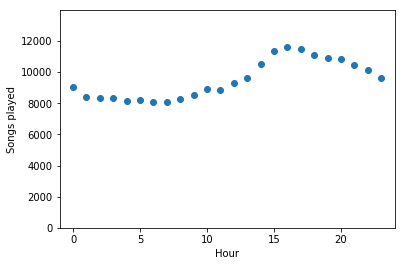

In [43]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Users Downgrade Their Accounts

To find when users downgrade their accounts, let's use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events and then flag those log entries

In [52]:
df_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  11|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38| 

In [74]:
df.select(["userId", "firstname", "page", "level", "song"]).where(df.userId == "59").collect()

[Row(userId='59', firstname='Jaleel', page='Home', level='free', song=None),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='The Great Depression'),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='Er kan altijd nog een tandje bij'),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song="I'm Not Calling You A Liar"),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='Seven Months'),
 Row(userId='59', firstname='Jaleel', page='Add Friend', level='free', song=None),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='The Breaks'),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='Substance (Felix Da Housecat Remix)'),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='The Guy That Says Goodbye To You Is Out Of His Mind'),
 Row(userId='59', firstname='Jaleel', page='NextSong', level='free', song='Them Bones'),
 Row(userId=

In [65]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [66]:
df_valid = df_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [67]:
df_valid.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='18', downgraded=0, phase=0)

In [68]:
from pyspark.sql import Window

In [69]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [70]:
df_valid = df_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [71]:
df_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(df.userId == "131").sort("ts").collect()

[Row(userId='131', firstname='Kael', ts=1538384355000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538384770000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385046000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385180000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385402000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385558000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386074000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386309000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386520000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386726000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.